# Basic Training Loop for MIS problem inference
This note book aims to give a simple example of how to create a simple training loop for MIS solution prediction. It is structured in the following manner:
- Instance generation:
  - Labeling: how to solve the problem and create labels for training
  - Creating the Bipartite graph that represents the problem
- Model definition
- Training loop


In [1]:
import sys
sys.path.insert(0,"..")

import networkx as nx
import torch_geometric as tg
import torch
import numpy as np
import bpropy
import matplotlib.pyplot as plt
import time

## Instance generation
In this section we will review the process of generating MIS instances with `bpropy` and `networkx` and how to solve them. First we will import the module `bpropy.co.mis` to have acces to the `MIS` class definition.

In [2]:
from bpropy.co.mis import MIS

Now lets create a graph using the Erdos-Renyi generation method implemented in `networkx`

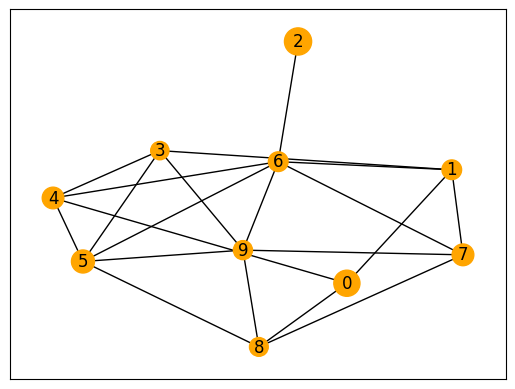

In [3]:
g = nx.generators.random_graphs.erdos_renyi_graph(10, 0.50)
pos = nx.layout.kamada_kawai_layout(g)
# node weights
w = np.random.rand(10)
nx.draw_networkx(g, pos=pos, node_color="orange", node_size=100+300*w)

Now we can create a MIS instance with

In [4]:

pb = MIS(g, weights=w)

We can solve the problem by calling the `MIS.solve` method

In [5]:
sol = pb.solve(solver="scipy")
print(sol.x)

[ 1. -0.  1.  0. -0.  1.  0.  1. -0. -0.]


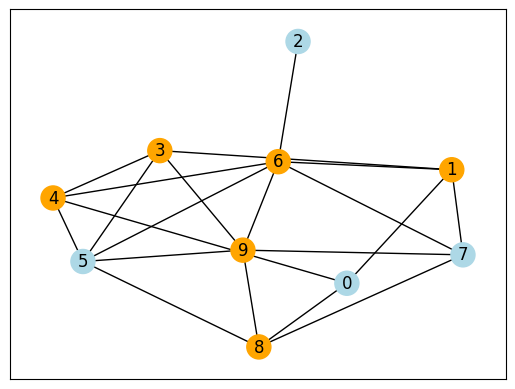

In [6]:
node_color = []
for n in pb.g.nodes():
    if sol.x[n] == 1:
        node_color.append("lightblue")
    else:
        node_color.append("orange")
nx.draw_networkx(pb.g, node_color=node_color, pos=pos)

## Dataset generation
We will create a train dataset of 100 graphs with solutions, and a test set with 10 graphs and solutions. First lets define a `generate_instance_and_solution` function to generate a random MIS and compute its solutions.

In [7]:
def generate_instance_and_solution(n=10, p=0.5):
    g = nx.generators.random_graphs.erdos_renyi_graph(n, p)
    pb = MIS(g, weights = np.ones(n))
    sol = pb.solve(solver="scipy")
    return (pb, sol)

In [8]:
train_dataset = [generate_instance_and_solution() for _ in range(100)]
validation_dataset = [generate_instance_and_solution() for _ in range(10)]
test_dataset = [generate_instance_and_solution() for _ in range(10)]

To use with `torch_geometric` GNNs we need to convert the `networkx` graphs and solutions to `torch_geometric.data.Data` objects. The `torch_geometric.utils.from_networkx` function transforms a `networkx.Graph` object to `torch_geometric.data.Data` object and fills in its `edge_index` and `num_nodes` attributes. We will manualy add the features `data.x` which represent the node weights and `data.y` representing the node labels (or targets).

In [9]:
def mis_and_solution_to_data(pb, sol):
    data = tg.utils.from_networkx(pb.g)
    data.x = torch.from_numpy(pb.w).unsqueeze(-1).to(torch.float)
    data.y = torch.from_numpy(sol.x).to(torch.float).unsqueeze(-1)
    
    return data
data = mis_and_solution_to_data(*train_dataset[0])
print(data)

Data(edge_index=[2, 50], num_nodes=10, x=[10, 1], y=[10, 1])


Now apply this function to all pairs of (problem,solution) in `train_dataset` and `test_dataset`

In [10]:
train_data = [mis_and_solution_to_data(pb,sol) for (pb,sol) in train_dataset]
validation_data = [mis_and_solution_to_data(pb,sol) for (pb,sol) in validation_dataset]
test_data = [mis_and_solution_to_data(pb,sol) for (pb,sol) in test_dataset]

In [11]:
print(train_data[0].x)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


## Defining the predictor
Lets now create a GNN with `torch_geometric`. The model is composed of 3 modules:
 - a GCNConv layer that transforms the 1-dimension input features into 2-dimensional vectors
 - a ELU non-linear activation function
 - a GCNConv layer that retransforms our 2-dimension features to 1-dimension scores

In [12]:
model = tg.nn.Sequential("x, edge_index", [
    (tg.nn.GCNConv(1, 2), "x, edge_index -> x"),
    torch.nn.ELU(),
    (tg.nn.GCNConv(2, 1), "x, edge_index -> x")
])

Let's test our model on the first `Data` object in our training dataset and see its output

In [13]:
model(train_data[0].x, train_data[0].edge_index)

tensor([[-0.3570],
        [-0.3909],
        [-0.2949],
        [-0.4139],
        [-0.2990],
        [-0.3559],
        [-0.3332],
        [-0.3248],
        [-0.4118],
        [-0.3889]], grad_fn=<AddBackward0>)

Note that we can access individual parameters of the model, these are the parameters we want to train through supervised learning

In [14]:
[p for p in model.parameters()]

[Parameter containing:
 tensor([0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[-0.2302],
         [ 0.2866]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4772, -0.9212]], requires_grad=True)]

We can also access the individual sub-modules of `model` (in our case there are 3: `module_0` is the first GCNConv, `module_1` is the ELU activation, and `module_2` is the final GCNConv layer)

In [15]:
model.module_0(train_data[0].x, train_data[0].edge_index)

tensor([[-0.2207,  0.2749],
        [-0.2498,  0.3111],
        [-0.1852,  0.2307],
        [-0.2702,  0.3365],
        [-0.1932,  0.2406],
        [-0.2207,  0.2749],
        [-0.2092,  0.2605],
        [-0.2029,  0.2526],
        [-0.2702,  0.3365],
        [-0.2452,  0.3054]], grad_fn=<AddBackward0>)

Let's retrieve the parameters of the first GCNConv layer

In [16]:
p_list = list(model.module_0.parameters())
bias = p_list[0]
weights = p_list[1]

model.module_0(train_data[0].x, train_data[0].edge_index) / torch.transpose(weights,0,1)

tensor([[0.9589, 0.9589],
        [1.0852, 1.0852],
        [0.8047, 0.8047],
        [1.1739, 1.1739],
        [0.8394, 0.8394],
        [0.9589, 0.9589],
        [0.9089, 0.9089],
        [0.8814, 0.8814],
        [1.1739, 1.1739],
        [1.0653, 1.0653]], grad_fn=<DivBackward0>)

## Basic training loop
Now lets implement a simple training loop to learn the parameters of our `model`. First step is to define a loss function

In [17]:
def loss(x_pred, x_target):
    return torch.nn.functional.binary_cross_entropy_with_logits(x_pred, x_target)

lambda_loss = lambda x_pred, x_target: torch.nn.functional.binary_cross_entropy_with_logits(x_pred, x_target)

Let's try our loss function

In [18]:
loss_val = loss(
    model(train_data[0].x, train_data[0].edge_index),
    train_data[0].y)
print("loss = ", loss_val)

loss =  tensor(0.6226, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Calling the `backward` function triggers the computation of the gradient by backpropagating the output along the computation tree. After calling `backward` the `grad` attribute of the model parameters are populated. The following shows the values of the gradients of the parameters of the `module_0` layer of our model.

In [19]:
print("Before backward bias.grad = ", bias.grad)
print("Before backward weights.grad = ", weights.grad)
loss_val.backward()
print("After backward bias.grad = ", bias.grad)
print("After backward weights.grad = ", weights.grad)

Before backward bias.grad =  None
Before backward weights.grad =  None
After backward bias.grad =  tensor([ 0.0576, -0.1398])
After backward weights.grad =  tensor([[ 0.0572],
        [-0.1392]])


To train our model we want to follow the opposite direction of the gradient of the loss function with regard to the parameters of the model. Lets try it on our train data

In [20]:
step_size = 0.1
loss_values = []
for epoch in range(50):
    epoch_loss = []
    for data in train_data:
        model.zero_grad()
        x_pred = model(data.x, data.edge_index)
        x_target = data.y
        loss_value = loss(x_pred, x_target)
        epoch_loss.append(loss_value.item()) # set aside the value of the loss for later computation and tracking
        # populate the gradient
        loss_value.backward()
        with torch.no_grad():
            for p in model.parameters():
                p += - step_size * p.grad
    loss_values.append(np.mean(epoch_loss))
    print(f"Epoch {epoch} loss {np.mean(epoch_loss)}")
    

Epoch 0 loss 0.6499221420288086
Epoch 1 loss 0.6416511476039887
Epoch 2 loss 0.6337455075979233
Epoch 3 loss 0.6259085553884506
Epoch 4 loss 0.6181941932439804
Epoch 5 loss 0.6106484293937683
Epoch 6 loss 0.6033052408695221
Epoch 7 loss 0.5961874908208847
Epoch 8 loss 0.5893089902400971
Epoch 9 loss 0.5826766437292099
Epoch 10 loss 0.5762922835350036
Epoch 11 loss 0.570153982937336
Epoch 12 loss 0.5642572185397148
Epoch 13 loss 0.558595632314682
Epoch 14 loss 0.553161626458168
Epoch 15 loss 0.5479467979073525
Epoch 16 loss 0.5429422661662102
Epoch 17 loss 0.538138969540596
Epoch 18 loss 0.5335277792811394
Epoch 19 loss 0.5290996128320694
Epoch 20 loss 0.524845638871193
Epoch 21 loss 0.5207571884989739
Epoch 22 loss 0.5168259179592133
Epoch 23 loss 0.5130438157916068
Epoch 24 loss 0.5094032040238381
Epoch 25 loss 0.505896717607975
Epoch 26 loss 0.5025173714756965
Epoch 27 loss 0.49925851076841354
Epoch 28 loss 0.4961138543486595
Epoch 29 loss 0.493077377974987
Epoch 30 loss 0.4901434296

We can visualise the loss datam

Text(0, 0.5, 'Loss')

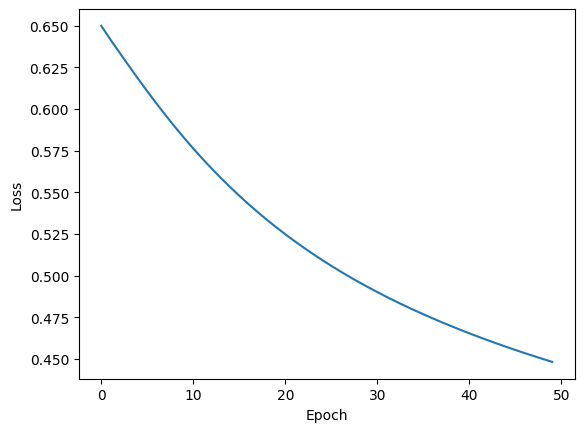

In [21]:
plt.figure()
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")

The training loop can be made more efficient by using optimizers from the `torch.optim` module such as the well known Adam optimizer. Start by initializing a new model.


In [22]:
model = tg.nn.Sequential("x, edge_index", [
    (tg.nn.GCNConv(1, 2), "x, edge_index -> x"),
    torch.nn.ELU(),
    (tg.nn.GCNConv(2, 1), "x, edge_index -> x")
])

In [23]:
step_size = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=step_size)

adam_loss_values = []
for epoch in range(50):
    epoch_loss = []
    for data in train_data:
        optimizer.zero_grad()
        x_pred = model(data.x, data.edge_index)
        x_target = data.y
        loss_value = loss(x_pred, x_target)
        epoch_loss.append(loss_value.item()) # set aside the value of the loss for later computation and tracking
        # populate the gradient
        loss_value.backward()
        optimizer.step()
    adam_loss_values.append(np.mean(epoch_loss))
    print(f"Epoch {epoch} loss {np.mean(epoch_loss)}")

Epoch 0 loss 0.6029409402608872
Epoch 1 loss 0.535809479355812
Epoch 2 loss 0.49621985644102096
Epoch 3 loss 0.47129834175109864
Epoch 4 loss 0.4544206175208092
Epoch 5 loss 0.44229633182287215
Epoch 6 loss 0.4331712493300438
Epoch 7 loss 0.42603191673755647
Epoch 8 loss 0.4202616326510906
Epoch 9 loss 0.4154700097441673
Epoch 10 loss 0.41140192821621896
Epoch 11 loss 0.4078855457901955
Epoch 12 loss 0.4048022206127644
Epoch 13 loss 0.4020675419270992
Epoch 14 loss 0.39962036192417144
Epoch 15 loss 0.39741490080952646
Epoch 16 loss 0.3954163764417171
Epoch 17 loss 0.39359727025032043
Epoch 18 loss 0.391935928016901
Epoch 19 loss 0.39041441679000854
Epoch 20 loss 0.38901752516627314
Epoch 21 loss 0.3877327559888363
Epoch 22 loss 0.38654891550540926
Epoch 23 loss 0.3854565569758415
Epoch 24 loss 0.3844469074904919
Epoch 25 loss 0.383512666374445
Epoch 26 loss 0.3826471637189388
Epoch 27 loss 0.38184410467743873
Epoch 28 loss 0.38109837882220743
Epoch 29 loss 0.3804050809144974
Epoch 30 l

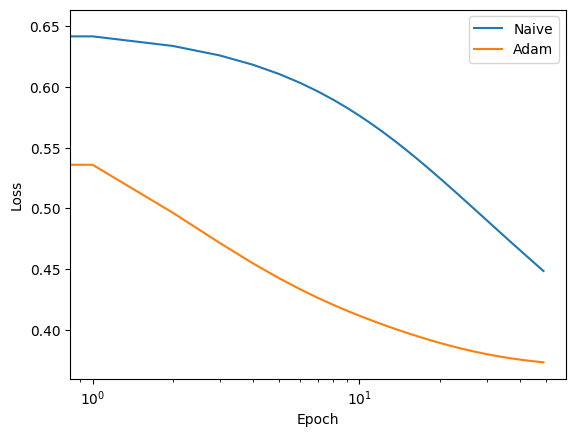

In [24]:
plt.figure()
plt.plot(loss_values, label="Naive")
plt.plot(adam_loss_values, label="Adam")
plt.xscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Adding a validation score
We are interested in solving the optimization problem, as such a good validation metric (variations of which indicate that the model is getting better at the task we want it to solve) is the **optimality gap**. Given a maximization problem $(P)$, $x^*$ the optimal solution and $x$ a candidate solution. We have that necessarily $c(x^*) \geq c(x)$. 

The optimiality gap of $x$, denoted by $\mathcal{O}(x^*,x)$ is defined : $\mathcal{O}(x^*,x) = \frac{ c(x^*) - c(x)}{c(x^*)}$

In [25]:
def optimality_gap(x_star, x, c):
    return (torch.dot(x_star, c) - torch.dot(x,c)) / torch.dot(x_star, c)

Try calculating the optimality gap for problem `pb` between the solution given by using `solve` without specifying the solver and a `greedy` solution. 

First solve with B&B

In [26]:
t_default = time.time()
sol_default = pb.solve(solver="solver") # solve with branch-and-bound
t_default = time.time() - t_default
val_default = np.dot(sol_default.x, pb.w)
print(f"Default solver time = {t_default}s, objective = {val_default}")

Default solver time = 4.528306245803833s, objective = 2.5126654883399544


Now solve with greedy

In [27]:
t_greedy = time.time()
sol_greedy = pb.greedy() # solve with branch-and-bound
t_greedy = time.time() - t_greedy
val_greedy = np.dot(sol_greedy, pb.w)
print(f"Greedy solver time = {t_greedy}s, objective = {val_greedy}")

Greedy solver time = 0.00023055076599121094s, objective = 2.5126654883399544


And the optimality gap

In [28]:
print("Optimality gap = ", optimality_gap(
    torch.from_numpy(sol_default.x), 
    torch.from_numpy(sol_greedy), 
    torch.from_numpy(pb.w)))

Optimality gap =  tensor(0., dtype=torch.float64)


Rather than solving the problem with an exact method such as B&B which can take an exponential amount of time for hard problems, our objective is to train the GNN to predict scores that can guide the greedy construction of a solution toward high quality solutions.

Note that it is obvious that such scores exist since taking $x^*$ as scores for our greedy procedure yields the optimal solution.

In [32]:
model = tg.nn.Sequential("x, edge_index", [
    (tg.nn.GCNConv(1, 64), "x, edge_index -> x"),
    torch.nn.Dropout(0.1),
    torch.nn.LayerNorm(64),
    torch.nn.ELU(),
    (tg.nn.GCNConv(64, 64), "x, edge_index -> x"),
    torch.nn.Dropout(0.1),
    torch.nn.LayerNorm(64),
    torch.nn.ELU(),
    (tg.nn.GCNConv(64, 64), "x, edge_index -> x"),
    torch.nn.Dropout(0.1),
    torch.nn.LayerNorm(64),
    torch.nn.ELU(),
    (tg.nn.GCNConv(64, 64), "x, edge_index -> x"),
    torch.nn.Dropout(0.1),
    torch.nn.LayerNorm(64),
    torch.nn.ELU(),
    (tg.nn.GCNConv(64, 1), "x, edge_index -> x"),
])


step_size = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=step_size)

adam_loss_values = []
adam_validation_values = []
for epoch in range(100):
    epoch_loss = []
    for data in train_data:
        optimizer.zero_grad()
        x_pred = model(data.x, data.edge_index)
        x_target = data.y
        loss_value = loss(x_pred, x_target)
        epoch_loss.append(loss_value.item()) # set aside the value of the loss for later computation and tracking
        # populate the gradient
        loss_value.backward()
        optimizer.step()

    # validation step
    val_values = []
    with torch.no_grad():
        for ((pb,sol),data) in zip(validation_dataset, validation_data):
            scores = model(data.x, data.edge_index)
            x_target = data.y.flatten()
            x_pred = torch.from_numpy(pb.greedy(scores = scores)).to(torch.float)
            weights = torch.from_numpy(pb.w).to(torch.float)
            # optimality gap
            gap = optimality_gap(x_target.flatten(), x_pred, weights)
            val_values.append(gap)
    adam_loss_values.append(np.mean(epoch_loss))
    adam_validation_values.append(np.mean(val_values))
    print(f"Epoch {epoch} loss = {np.mean(epoch_loss)} val_gap = {np.mean(val_values)}")

Epoch 0 loss = 0.6562429976463318 val_gap = 0.0
Epoch 1 loss = 0.6515598088502884 val_gap = 0.05000000074505806
Epoch 2 loss = 0.6481187778711319 val_gap = 0.05000000074505806
Epoch 3 loss = 0.6476658928394318 val_gap = 0.05000000074505806
Epoch 4 loss = 0.6449243259429932 val_gap = 0.05000000074505806
Epoch 5 loss = 0.6432817310094834 val_gap = 0.05000000074505806
Epoch 6 loss = 0.6411026555299759 val_gap = 0.02500000037252903
Epoch 7 loss = 0.6398113000392914 val_gap = 0.07500000298023224
Epoch 8 loss = 0.6379752379655838 val_gap = 0.02500000037252903
Epoch 9 loss = 0.6348820078372955 val_gap = 0.05000000074505806
Epoch 10 loss = 0.6339638197422027 val_gap = 0.05000000074505806
Epoch 11 loss = 0.6320501321554184 val_gap = 0.02500000037252903
Epoch 12 loss = 0.630564404129982 val_gap = 0.07500000298023224
Epoch 13 loss = 0.6307033878564835 val_gap = 0.07500000298023224
Epoch 14 loss = 0.6278476178646087 val_gap = 0.05000000074505806
Epoch 15 loss = 0.6257308441400528 val_gap = 0.05000

KeyboardInterrupt: 

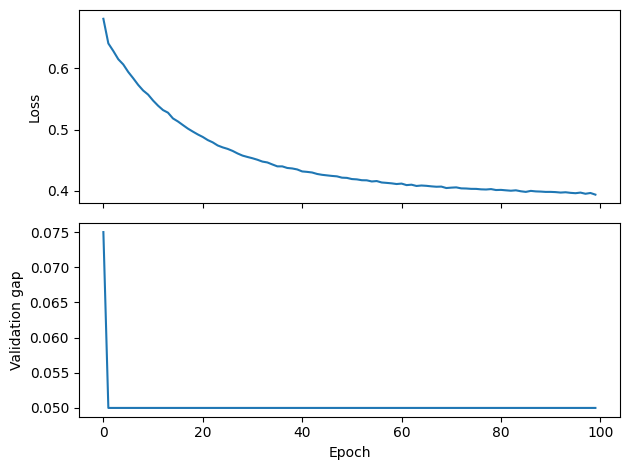

In [30]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(adam_loss_values)
ax[0].set_ylabel("Loss")
ax[1].plot(adam_validation_values)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation gap")
plt.tight_layout()